In [248]:
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import time

import cv2
import matplotlib.pyplot as plt

In [105]:
img = cv2.imread("../asset/001.png")
bboxes = np.loadtxt("./001_line_coords.txt", delimiter=',', dtype=int)
THICKNESS = 2
np.random.seed(73)

In [267]:
def convert2polygon(bbox):
    assert len(bbox) == 8, bbox
    return Polygon([bbox[6:8], bbox[4:6], bbox[2:4], bbox[0:2]])

def almost_contains(p1, p2, epsilon=1e-2):
    if p1.area >= p2.area:
        return (p2.difference(p1).area / p1.area) < epsilon
    else:
        return False

def in_same_line(bbox1, bbox2, epsilon=2e-1):
    bbox1_mean_y = np.mean(bbox1[[1, 3, 5, 7]])
    bbox2_mean_y = np.mean(bbox2[[1, 3, 5, 7]])
    bbox1_height = np.max(bbox1[[1, 3, 5, 7]]) - np.min(bbox1[[1, 3, 5, 7]])
    bbox2_height = np.max(bbox2[[1, 3, 5, 7]]) - np.min(bbox2[[1, 3, 5, 7]])
    
    return np.abs(bbox1_mean_y - bbox2_mean_y) / np.minimum(bbox1_height, bbox2_height) < epsilon

def merge_polygons(p1, p2):
    
    p3 = cascaded_union([p1, p2])
    try:
        bbox_merged = np.vstack((p3.minimum_rotated_rectangle.exterior.coords.xy)).flatten(order='F')[:-2].astype(int)
#         bbox_merged = np.vstack((p3.exterior.coords.xy)).flatten(order='F')[:-2].astype(int)
    except AttributeError:
#         return [bbox1, bbox2]
        return []
    return [bbox_merged]

def draw_bboxes(img, bboxes):
    res = img.copy()
    for bbox in bboxes:
        n = len(bbox)
        if n < 4:
            continue
        if n % 2 == 1:
            bbox = bbox[:n - 1]
        try:
            bbox = bbox.astype(int)
        except (ValueError, AttributeError):
            continue

        random_color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        if len(bbox) == 4:
            cv2.rectangle(res, tuple(bbox[:2]), tuple(bbox[2:]), color=random_color, thickness=THICKNESS)
        elif len(bbox) > 4:
            cv2.drawContours(res, [bbox.reshape(-1, 2)], -1, color=random_color, thickness=THICKNESS)
            # cv2.polylines(img, [coord.astype(np.int).reshape((-1, 1, 2))], True, color=random_color, thickness=5)
            
    return res

def merge_all(bboxes, epsilon=2e-1):
    _merged_bboxes = []
    merge_counter = 0
    
    print("Bbox count:", len(bboxes))
    for bbox1 in bboxes:
        for bbox2 in bboxes:
            
            ## If same boxes, pass
            if np.all(np.array(bbox1) == np.array(bbox2)):
                continue
                
            p1 = convert2polygon(bbox1)
            p2 = convert2polygon(bbox2)
    
#             ## If bbox1 is a sub box, break
#             if p2.contains(p1):
#                 break
                
            ## If bbox1 is almost a sub box, break
            if almost_contains(p2, p1):
                break
            
            ## If not in same line, pass
            if in_same_line(bbox1, bbox2, epsilon=epsilon):
                if p1.intersects(p2):
                    merged = merge_polygons(p1, p2)
                    _merged_bboxes.extend(merged)
                    merge_counter += 1
                    break
        else:
            _merged_bboxes.extend([bbox1])
    print(merge_counter, "merged")
    _merged_bboxes = np.unique(np.array(_merged_bboxes), axis=0)
    if merge_counter > 0:
        return merge_all(_merged_bboxes, epsilon=epsilon)
    else:
        return bboxes

In [264]:
start = time.time()
merged_bb = merge_all(bboxes, epsilon=3e-1)
print("Takes {:.4f} seconds".format(time.time() - start))
print("Final bboxes:", len(merged_bb))

Bbox count: 256
203 merged
Bbox count: 27
0 merged
Takes 2.9170 seconds
Final bboxes: 27


In [266]:
start = time.time()
merged_bb = merge_all(bboxes, epsilon=3e-1)
print("Takes {:.4f} seconds".format(time.time() - start))
print("Final bboxes:", len(merged_bb))

Bbox count: 256
203 merged
Bbox count: 27
0 merged
Takes 3.0493 seconds
Final bboxes: 27


In [234]:
unmerged_img = draw_bboxes(img, bboxes)
merged_img = draw_bboxes(img, merged_bb)

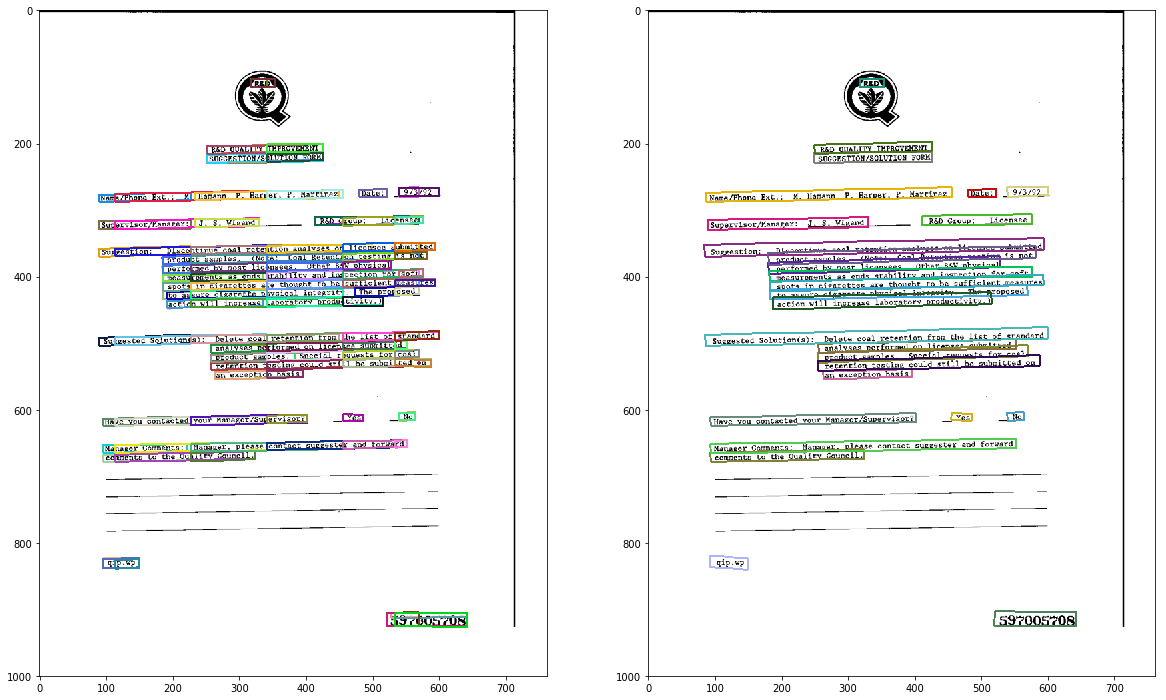

In [235]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(unmerged_img)

plt.subplot(1, 2, 2)
plt.imshow(merged_img)

plt.show()

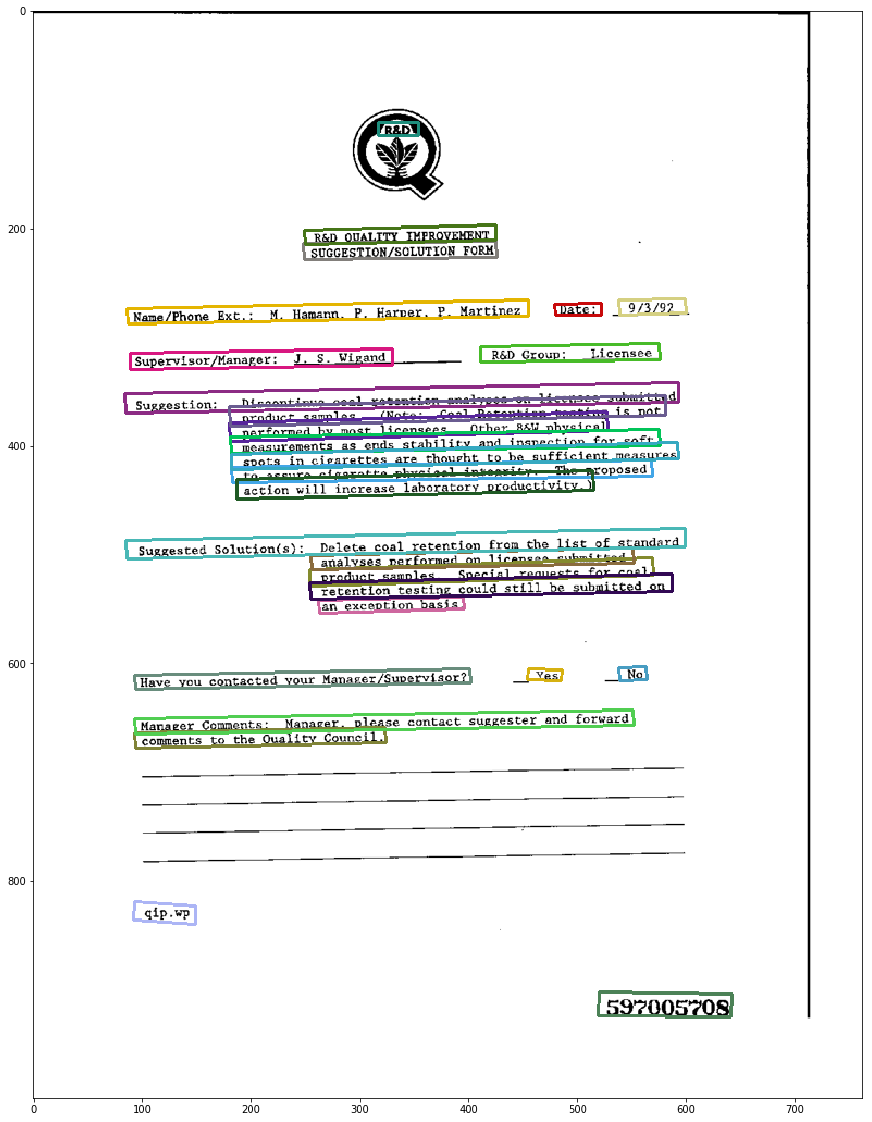

In [236]:
plt.figure(figsize=(20, 20))
plt.imshow(merged_img)
plt.show()

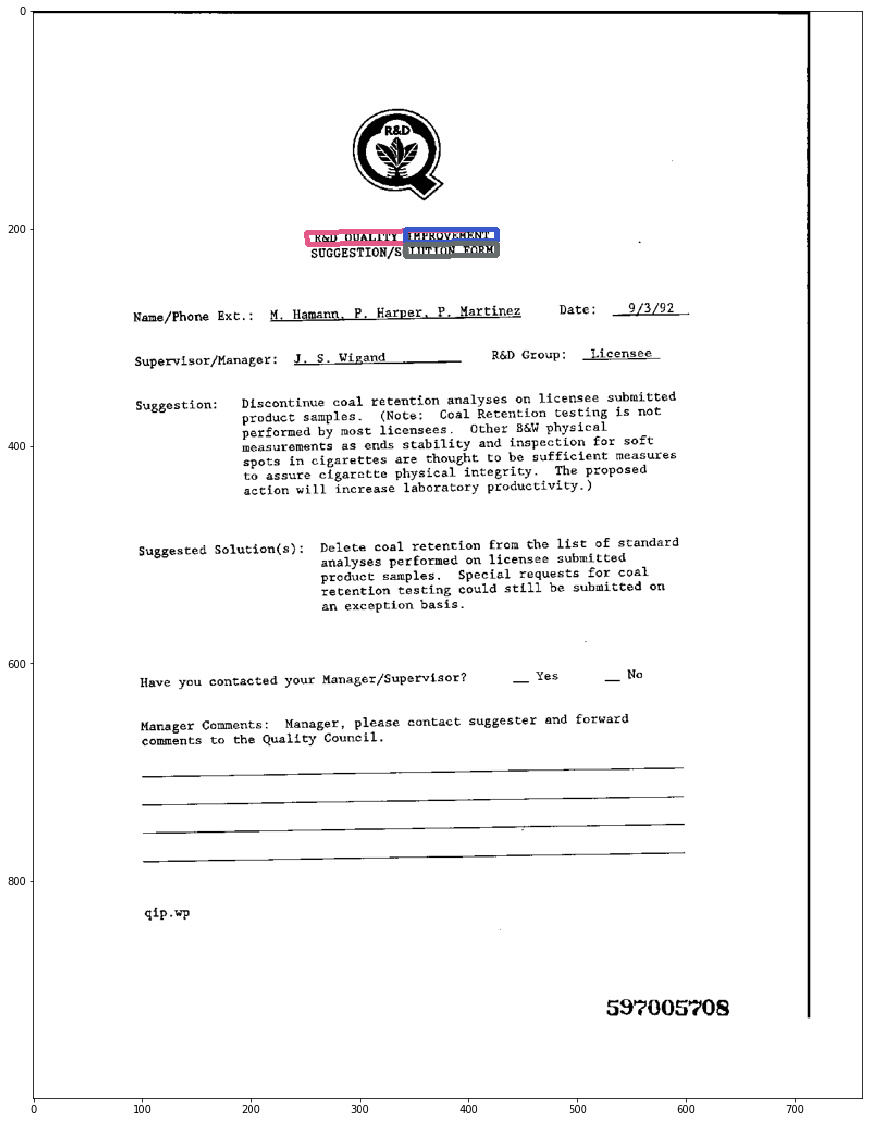

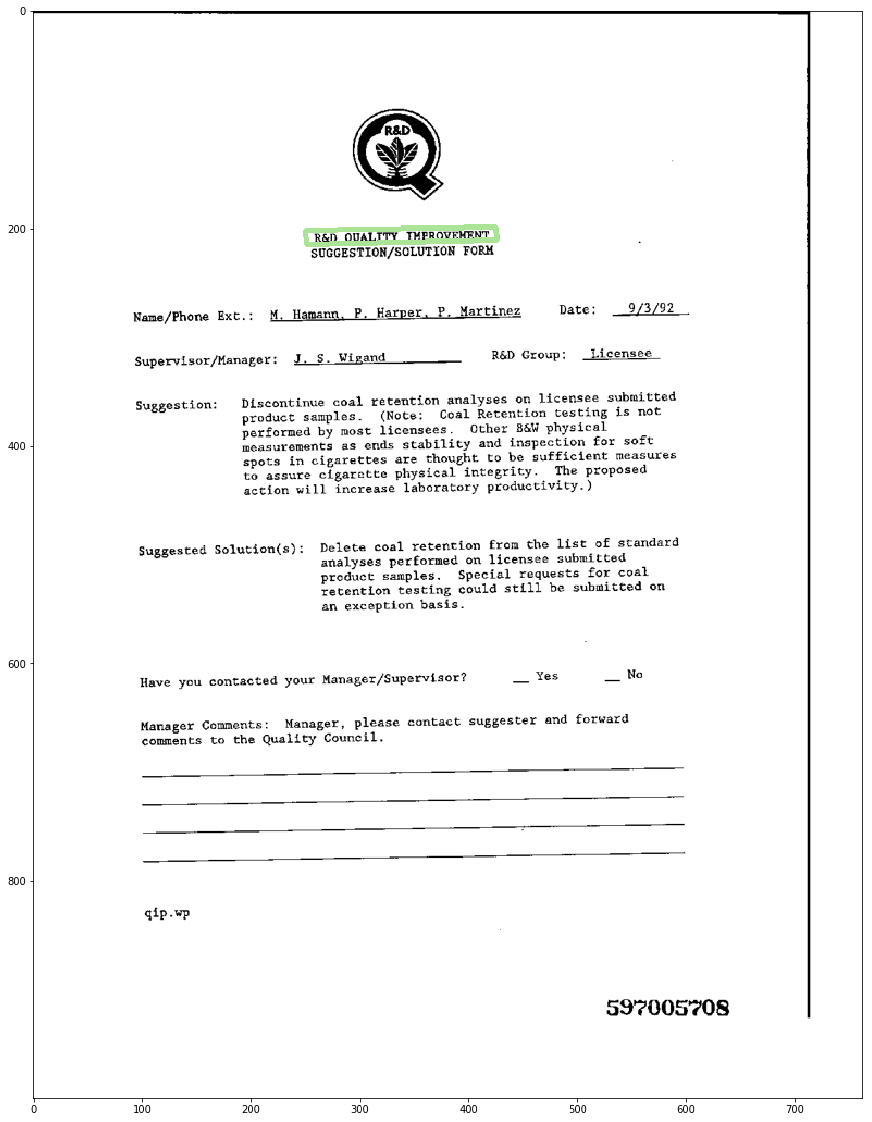

Not in same line


In [53]:
## Merge test
one_line_img = draw_bboxes(img, bboxes[5:8])
plt.figure(figsize=(20, 20))
plt.imshow(one_line_img)
plt.show()

if in_same_line(bboxes[5], bboxes[6], epsilon=4e-1):
    one_line_img_merged = draw_bboxes(img, merge_pairs(bboxes[5], bboxes[6]))
    plt.figure(figsize=(20, 20))
    plt.imshow(one_line_img_merged)
    plt.show()
else:
    print("Not in same line")
    
if in_same_line(bboxes[6], bboxes[7], epsilon=2e-1):
    one_line_img_merged = draw_bboxes(img, merge_pairs(bboxes[6], bboxes[7]))
    plt.figure(figsize=(20, 20))
    plt.imshow(one_line_img_merged)
    plt.show()
else:
    print("Not in same line")

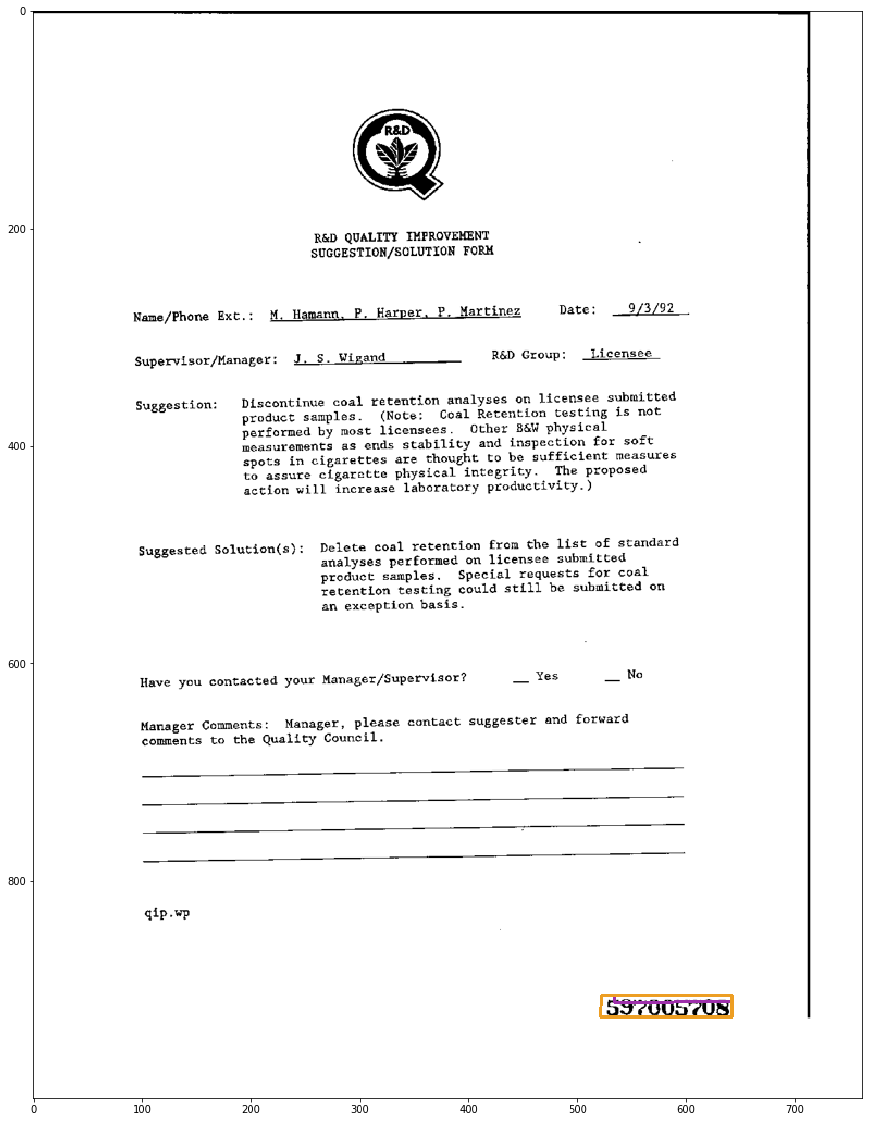

In [239]:
## Test
one_line_img = draw_bboxes(img, bboxes[[-13, -3]])
plt.figure(figsize=(20, 20))
plt.imshow(one_line_img)
plt.show()

In [240]:
bbox1 = bboxes[-3]
bbox2 = bboxes[-13]
p1 = Polygon([bbox1[:2], bbox1[2:4], bbox1[4:6], bbox1[6:8]])
p2 = Polygon([bbox2[:2], bbox2[2:4], bbox2[4:6], bbox2[6:8]])

In [241]:
p1.area

2410.0

In [242]:
p2.area

702.0

In [243]:
p1.intersection(p2).area

702.0

In [244]:
p1.difference(p2).area

1708.0

In [245]:
p2.difference(p1).area

0.0